# Importing the Libraries

In [2]:
import pandas as pd
import numpy as np 
import tensorflow as tf
import seaborn as sns
from matplotlib import image
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras as k

In [199]:
import os,glob
from PIL import Image
from keras.preprocessing.image import img_to_array

In [4]:
train_data_dir=r"C:\Users\pavan\OneDrive\Desktop\Assignments\Machine Learning - 7072\archive (7)\Garbage classification\Garbage classification"

# Number of Classes

In [5]:
types=os.listdir(train_data_dir)
print("Number of classes:",len(types))
print(types)

Number of classes: 6
['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


# Number of images in each class

Number of images in each type
cardboard:403
glass:501
metal:410
paper:594
plastic:482
trash:137


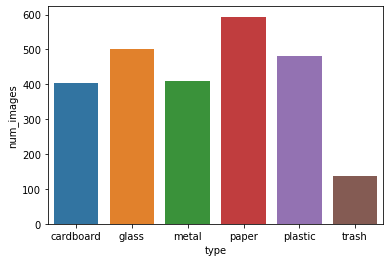

In [6]:
print("Number of images in each type")
num_images=[]
for each_type in types:
    type_link=os.path.join(train_data_dir,each_type)
    print(each_type+':'+str(len(os.listdir(type_link))))
    num_images.append(len(os.listdir(type_link)))
    

num_images=pd.DataFrame({'type':types,'num_images':num_images})
sns.barplot(x=num_images['type'],y=num_images['num_images']);

# Plot n number of images in each type

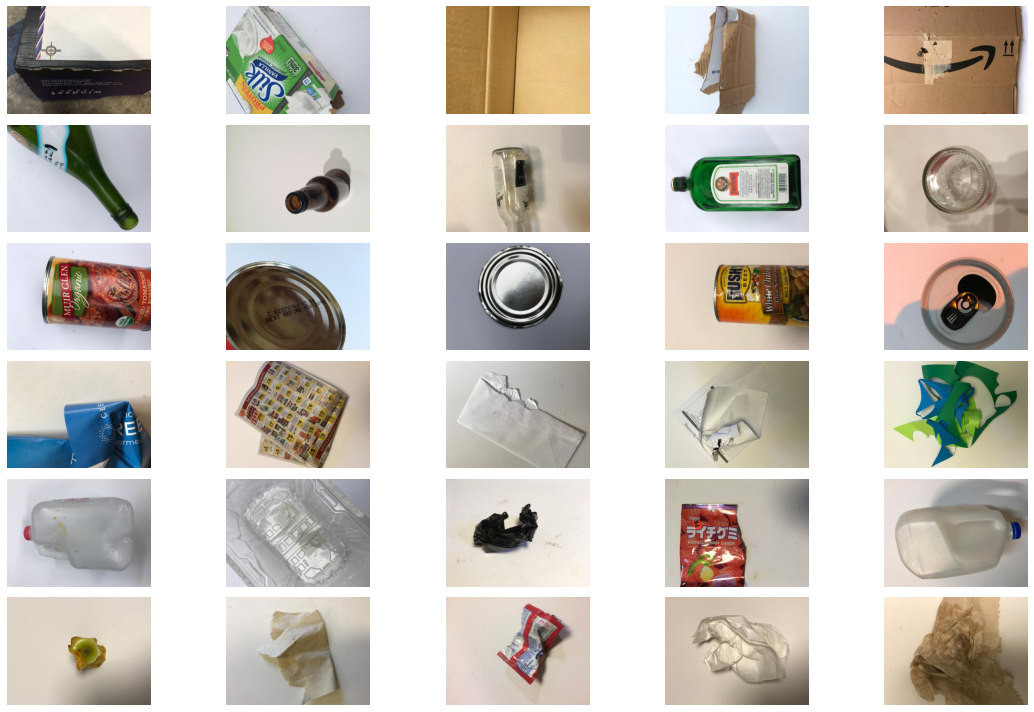

In [7]:
n=5
fig,ax=plt.subplots(nrows=len(types),ncols=n,figsize=(16,10))
for i,each_type in enumerate(types):
    each_type_images=os.path.join(train_data_dir,each_type)
    random_n=random.choices(os.listdir(each_type_images),k=n)
    ax[i][0].set_ylabel('each_type')
    for j in range(n):
        each_image=os.path.join(each_type_images,random_n[j])
        data=image.imread(each_image)
        ax[i][j].imshow(data)
        ax[i][j].axis('off')
    plt.tight_layout()
    
    
#https://stackoverflow.com/questions/6963035/pyplot-common-axes-labels-for-subplots 

# Image Generator- includes data augumentation, batch size, data splitting

It is possible to write code to manually load image data and return data ready for modeling.

This would include walking the directory structure for a dataset, loading image data, and returning the input (pixel arrays) and output (class integer).

Thankfully, we don’t need to write this code. Instead, we can use the ImageDataGenerator class provided by Keras.

The main benefit of using this class to load the data is that images are loaded for a single dataset in batches, meaning that it can be used for loading both small datasets as well as very large image datasets with thousands or millions of images.

Instead of loading all images into memory, it will load just enough images into memory for the current and perhaps the next few mini-batches when training and evaluating a deep learning model. I refer to this as progressive loading, as the dataset is progressively loaded from file, retrieving just enough data for what is needed immediately.

In [8]:
#https://machinelearningmastery.com/how-to-load-large-datasets-from-directories-for-deep-learning-with-keras/

In [108]:
#Image data generator for training
train_data=ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.1
)
#brightness_range=[0.6,1.0]

#Image data generator for testing
test_data = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.1
)

#
train_gen=train_data.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=0
)

validation_gen = test_data.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    class_mode='categorical',
    subset='validation',
    seed=0,shuffle=False
)

labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [10]:
from tensorflow.keras.applications.vgg16 import preprocess_input


model_vgg=k.applications.vgg16.VGG16(include_top=False,
    weights='imagenet',
    input_shape=(224,224,3))
model_vgg.trainable=False

In [11]:
model_vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [246]:
from tensorflow.keras import layers,Sequential,models

flatten_layer = layers.Flatten()
dense_layer1= layers.Dense(256, activation='relu')
dense_layer2 = layers.Dense(64, activation='relu')
final_layer = layers.Dense(6, activation='softmax')


model = models.Sequential([
    model_vgg,
    flatten_layer,
    dense_layer1,
    dense_layer2,
    final_layer
])

In [247]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dense_16 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_17 (Dense)             (None, 6)                 390       
Total params: 21,154,310
Trainable params: 6,439,622
Non-trainable params: 14,714,688
_________________________________________________________________


In [212]:
# It takes around 45min for each execution


#Things to do
#1.Use Adam optimizer and different learning rates and different batch sizes
#learning rate range- [0.0001,0.01]
#Batch sizes -[16,32,64]
#Optimiozers - Adam, Nadam, stochastic
#2.Use xception model- different optimizers, learning rates, batch sizes

In [160]:
#Nadam optimizer with learning rate=0.01
model.compile(optimizer=k.optimizers.Adam(learning_rate=0.001),
              loss='categorical_crossentropy',metrics=['accuracy'])

model.fit(train_gen,
          epochs=10,
          validation_data=validation_gen)

Epoch 1/10
143/143 [==============================] - 263s 2s/step - loss: 0.4685 - accuracy: 0.8286 - val_loss: 0.6221 - val_accuracy: 0.7968
Epoch 2/10
143/143 [==============================] - 313s 2s/step - loss: 0.4723 - accuracy: 0.8330 - val_loss: 0.6481 - val_accuracy: 0.7809
Epoch 3/10
143/143 [==============================] - 317s 2s/step - loss: 0.4238 - accuracy: 0.8484 - val_loss: 0.6652 - val_accuracy: 0.8008
Epoch 4/10
143/143 [==============================] - 316s 2s/step - loss: 0.3982 - accuracy: 0.8559 - val_loss: 0.6893 - val_accuracy: 0.7570
Epoch 5/10
143/143 [==============================] - 349s 2s/step - loss: 0.4218 - accuracy: 0.8383 - val_loss: 0.6135 - val_accuracy: 0.7849
Epoch 6/10
143/143 [==============================] - 351s 2s/step - loss: 0.3285 - accuracy: 0.8779 - val_loss: 0.6087 - val_accuracy: 0.8008
Epoch 7/10
143/143 [==============================] - 351s 2s/step - loss: 0.3479 - accuracy: 0.8796 - val_loss: 0.5630 - val_accuracy: 0.8127

In [17]:
from keras import regularizers, optimizers

resnet60_model= tf.keras.applications.DenseNet121(include_top=False,
                   input_shape=(224,224,3),
                   weights='imagenet')
resnet60_model.trainable=False
#for layer in pretrained_model.layers:
#        layer.trainable=False

model2=Sequential()
model2.add(resnet60_model)
model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='elu',kernel_regularizer=regularizers.l2(0.1)))
model2.add(layers.Dropout(0.4))
model2.add(layers.BatchNormalization())
#model2.add(layers.Dense(64, activation='elu'))
model2.add(layers.Dense(6, activation='softmax'))

In [18]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               25690624  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 3078      
Total params: 32,733,254
Trainable params: 25,694,726
Non-trainable params: 7,038,528
__________________________________

In [19]:
#model2.compile(optimizer=k.optimizers.Adam(learning_rate=0.0001),
#              loss='categorical_crossentropy',metrics=['accuracy'])

optimizer = optimizers.SGD(lr=0.0001, momentum=0.9, nesterov=True)
#optimizer=optimizers.Adam(learning_rate=0.01)
model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model2.fit(train_gen,
          epochs=15,
          validation_data=validation_gen)

Epoch 1/15
72/72 [==============================] - 121s 2s/step - loss: 101.5694 - accuracy: 0.5303 - val_loss: 99.6950 - val_accuracy: 0.7012
Epoch 2/15
72/72 [==============================] - 121s 2s/step - loss: 98.3392 - accuracy: 0.6902 - val_loss: 96.6756 - val_accuracy: 0.7570
Epoch 3/15
72/72 [==============================] - 121s 2s/step - loss: 95.4234 - accuracy: 0.7390 - val_loss: 93.9119 - val_accuracy: 0.7849
Epoch 4/15
72/72 [==============================] - 122s 2s/step - loss: 92.6277 - accuracy: 0.7746 - val_loss: 91.2090 - val_accuracy: 0.7968
Epoch 5/15
72/72 [==============================] - 123s 2s/step - loss: 89.9981 - accuracy: 0.7830 - val_loss: 88.6478 - val_accuracy: 0.7849
Epoch 6/15
72/72 [==============================] - 5827s 81s/step - loss: 87.4001 - accuracy: 0.8010 - val_loss: 86.1062 - val_accuracy: 0.8088
Epoch 7/15
72/72 [==============================] - 111s 2s/step - loss: 84.8816 - accuracy: 0.8260 - val_loss: 83.6694 - val_accuracy: 0.8

In [229]:
from keras import regularizers, optimizers

resnet60_model= tf.keras.applications.DenseNet121(include_top=False,
                   input_shape=(224,224,3),
                   weights='imagenet')
resnet60_model.trainable=False
#for layer in pretrained_model.layers:
#        layer.trainable=False

model3=Sequential()
model3.add(resnet60_model)
model3.add(layers.Flatten())
model3.add(layers.Dense(512, activation='elu',kernel_regularizer=regularizers.l2(0.1)))
model3.add(layers.Dropout(0.4))
model3.add(layers.BatchNormalization())
#model3.add(layers.Dense(64, activation='elu'))
model3.add(layers.Dense(6, activation='softmax'))

In [230]:
model3.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
flatten_5 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               25690624  
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_14 (Dense)             (None, 6)                 3078      
Total params: 32,733,254
Trainable params: 25,694,726
Non-trainable params: 7,038,528
__________________________________

In [232]:
#model2.compile(optimizer=k.optimizers.Adam(learning_rate=0.0001),
#              loss='categorical_crossentropy',metrics=['accuracy'])

optimizer = optimizers.SGD(lr=0.0001, momentum=0.9, nesterov=True)
#optimizer=optimizers.Adam(learning_rate=0.01)
model3.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history=model3.fit(train_gen,
          epochs=15,
          validation_data=validation_gen)

Epoch 1/15
72/72 [==============================] - 126s 2s/step - loss: 101.4035 - accuracy: 0.5369 - val_loss: 99.5747 - val_accuracy: 0.6932
Epoch 2/15
72/72 [==============================] - 141s 2s/step - loss: 98.2178 - accuracy: 0.6920 - val_loss: 96.6609 - val_accuracy: 0.7410
Epoch 3/15
72/72 [==============================] - 142s 2s/step - loss: 95.3188 - accuracy: 0.7403 - val_loss: 93.8657 - val_accuracy: 0.7649
Epoch 4/15
72/72 [==============================] - 142s 2s/step - loss: 92.5650 - accuracy: 0.7579 - val_loss: 91.1209 - val_accuracy: 0.7849
Epoch 5/15
72/72 [==============================] - 154s 2s/step - loss: 89.8947 - accuracy: 0.7834 - val_loss: 88.5293 - val_accuracy: 0.7968
Epoch 6/15
72/72 [==============================] - 141s 2s/step - loss: 87.3202 - accuracy: 0.7975 - val_loss: 85.9748 - val_accuracy: 0.8127
Epoch 7/15
72/72 [==============================] - 139s 2s/step - loss: 84.8023 - accuracy: 0.8023 - val_loss: 83.5707 - val_accuracy: 0.788

In [97]:
model2.evaluate(validation_gen)

8/8 [==============================] - 9s 1s/step - loss: 66.4929 - accuracy: 0.8327


[66.49293518066406, 0.8326693177223206]

In [214]:
results=model2.predict(validation_gen)
conf_matix=confusion_matrix(results.argmax(axis=1),validation_gen.classes)
conf_matix

array([[32,  0,  1,  3,  1,  0],
       [ 0, 43,  2,  0,  8,  0],
       [ 2,  3, 36,  0,  2,  1],
       [ 5,  0,  2, 53,  1,  2],
       [ 0,  4,  0,  2, 36,  1],
       [ 1,  0,  0,  1,  0,  9]], dtype=int64)

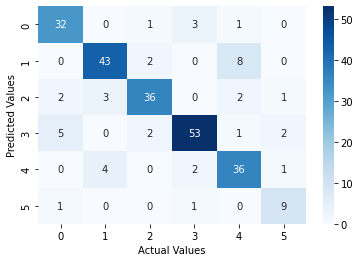

In [122]:
sns.heatmap(conf_matix, annot=True, cmap='Blues')
plt.ylabel("Predicted Values")
plt.xlabel("Actual Values");

In [194]:
results_dic={}
for i,j in validation_gen.class_indices.items():
    results_dic[j]=i

In [196]:
def predict(image,results_dic):
    plt.imshow(image)
    plt.axis("off");
    image=image.resize((224,224))
    image_array=img_to_array(image).reshape(1,224,224,3)
    image_array=image_array/255
    result=model2.predict(image_array).argmax(axis=1)
    print("predicted class:",results_dic[result[0]])

predicted class: metal


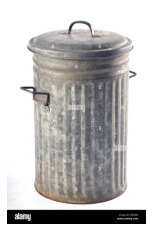

In [201]:
image=Image.open(r"C:\Users\pavan\OneDrive\Desktop\Assignments\Machine Learning - 7072\metal_test.jpg")
predict(image,results_dic)

predicted class: cardboard


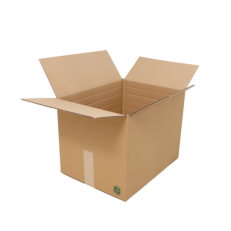

In [204]:
image=Image.open(r"C:\Users\pavan\OneDrive\Desktop\Assignments\Machine Learning - 7072\cardboard_test.jpg")
predict(image,results_dic)

predicted class: plastic


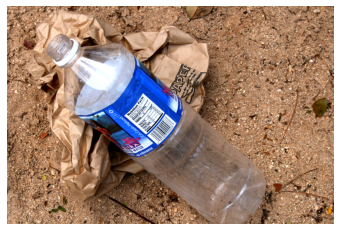

In [248]:
image=Image.open(r"C:\Users\pavan\OneDrive\Desktop\Assignments\Machine Learning - 7072\plastic_test.jpg")
predict(image,results_dic)

In [218]:
from sklearn.metrics import precision_recall_fscore_support
all_values=precision_recall_fscore_support(validation_gen.classes, results.argmax(axis=1), average=None)
all_values

(array([0.86486486, 0.81132075, 0.81818182, 0.84126984, 0.8372093 ,
        0.81818182]),
 array([0.8       , 0.86      , 0.87804878, 0.89830508, 0.75      ,
        0.69230769]),
 array([0.83116883, 0.83495146, 0.84705882, 0.86885246, 0.79120879,
        0.75      ]),
 array([40, 50, 41, 59, 48, 13], dtype=int64))

In [216]:
#Precision, recall, fscore values for each class
#support- The number of occurrences of each label in y_true

In [251]:
results_dic

{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}

In [219]:
precision=all_values[0]
recall=all_values[1]
fscore=all_values[2]

In [253]:
precision_df=pd.DataFrame({'Label':np.array(range(6)),'precision':fscore})
precision_df

,Label,precision
0,0,0.831169
1,1,0.834951
2,2,0.847059
3,3,0.868852
4,4,0.791209
5,5,0.750000


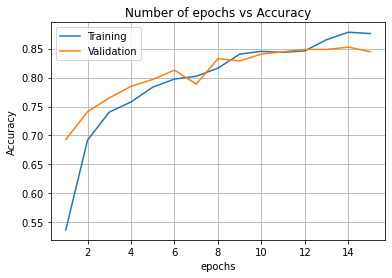

In [245]:
plt.plot(range(1,16),history.history['accuracy'])
plt.plot(range(1,16),history.history['val_accuracy'])
plt.legend(['Training','Validation'])
plt.xlabel('epochs')
plt.ylabel('Accuracy')
plt.title('Number of epochs vs Accuracy')
plt.grid();

predicted class: paper


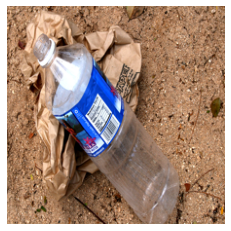

In [250]:
plt.imshow(image)
plt.axis("off");
image=image.resize((224,224))
image_array=img_to_array(image).reshape(1,224,224,3)
image_array=image_array/255
result=model.predict(image_array).argmax(axis=1)
print("predicted class:",results_dic[result[0]])